# SALUD MURCIA

In [1]:
from pandas import read_csv
import pandas as pd
from pandas.plotting import lag_plot
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import io

Lectura del conjunto de datos obtenido de la pagina de salud de Murcia 
https://www.murciasalud.es/pagina.php?id=458869
Recogidos desde el 08/03/2020 hasta el dia 25/03/2020

In [13]:
lectura = read_csv('../Datos_originales/casos_diarios_total_regional.csv', skiprows = 4, encoding='latin-1', sep = ';', na_values = ['NaN', 'NaT'])

# Headers = columnas de mi conjunto de datos. Si no especificamos asume que son las de la primera fila leida
# Skiprows = n: con n = numero de filas que quiero saltar. Las cuatro primeras son texto -> las saltamos
# Encoding = 'latin-1': para que no de errores de codificacion de algunos caracteres 
# Sep = ';': delimitador que separa las columnas
# Index_col = 0: usar la primera columna (fechas) como filas del dataframe

Renombramos los nombres de algunas de las columnas para que queden mas compactos

In [14]:
datos = lectura.rename(columns={'Pruebas_PCR_Ag':'Pruebas',
                                'Casos_incidentes_PCR/Ag+':'Incidentes',
                                'Hospitalizados': 'H',
                                'Hospitaliz_UCI':'H_UCI',
                                'Asintomatico_hombre_<45años': 'Asint_H_<45',
                                'Asintomatico_hombre_45a64años': 'Asint_H_45a64',
                                'Asintomatico_hombre_+65años': 'Asint_H_+65',
                                'Sintomatico_hombre_<45años': 'Sint_H_<45',
                                'Sintomatico_hombre_45a64años': 'Sint_H_45a64',
                                'Sintomatico_hombre_+65años': 'Sint_H_+65',
                                'Asintomatico_mujer_<45años': 'Asint_M_<45',
                                'Asintomatico_mujer_45a64años': 'Asint_M_45a64',
                                'Asintomatico_mujer_+65años': 'Asint_M_+65',
                                'Sintomatico_mujer_<45años': 'Sint_M_<45',
                                'Sintomatico_mujer_45a64años': 'Sint_M_45a64',
                                'Sintomatico_mujer_+65años': 'Sint_M_+65'})

Convertimos los datos leidos en un dataFrame y lo mostramos para ver su apariencia

In [15]:
df_salud_murcia = pd.DataFrame(datos)
df_salud_murcia.head(3)

,Fecha,Pruebas,Incidentes,H,H_UCI,Defunciones,Asint_H_<45,Asint_H_45a64,Asint_H_+65,Sint_H_<45,Sint_H_45a64,Sint_H_+65,Asint_M_<45,Asint_M_45a64,Asint_M_+65,Sint_M_<45,Sint_M_45a64,Sint_M_+65
0,08/03/2020,130.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,09/03/2020,21.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
2,10/03/2020,39.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0


Lo siguiente que haremos es indexar el dataframe por la columna 'Fecha'. Para ello, primero debemos convertir la misma en un objeto de tipo DatatimeIndex. Usamos la funcion 'to_datetime' y le indicamos el formato en el que se encuentran las fechas para que se lea y procese bien. Posteriormente eliminamos la columna del dataFrame e insertamos el nuevo DatatimeIndex como íncide del dataframe. Finalmente mostramos el resultado.

In [16]:
format = '%d/%m/%Y'
datetime_fecha = pd.to_datetime(df_salud_murcia['Fecha'], format = format)
df_salud_murcia = df_salud_murcia.drop(['Fecha'], axis=1)
df_salud_murcia.insert(0,'Fecha', datetime_fecha)
df_salud_murcia = df_salud_murcia.set_index('Fecha')
df_salud_murcia.head(3)

,Pruebas,Incidentes,H,H_UCI,Defunciones,Asint_H_<45,Asint_H_45a64,Asint_H_+65,Sint_H_<45,Sint_H_45a64,Sint_H_+65,Asint_M_<45,Asint_M_45a64,Asint_M_+65,Sint_M_<45,Sint_M_45a64,Sint_M_+65
Fecha,,,,,,,,,,,,,,,,,
2020-03-08,130.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2020-03-09,21.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
2020-03-10,39.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0


Con la siguiente función eliminamos todos aquellos valores que se almacenan o completan como NaN. 

In [17]:
df_salud_murcia.dropna(axis = 0, inplace = True)

## Sumando asintomáticos
En esta sección vamos a sumar a todos los asintomáticos (por fecha) y añadirlos en una nueva serie
del dataframe a la que llamaré "Asintomaticos"

In [18]:
df_salud_murcia['Asintomaticos'] = df_salud_murcia['Asint_H_<45'] + df_salud_murcia['Asint_H_45a64'] + df_salud_murcia['Asint_H_+65'] + df_salud_murcia['Asint_M_<45'] + df_salud_murcia['Asint_M_45a64'] + df_salud_murcia['Asint_M_+65']

A continuación lo que hacemos es guardarla en un archivo de extensión .csv 

In [ ]:
df_salud_murcia.to_csv(path_or_buf = '../Datos_preprocesados./datos_murcia_mas_asintomaticos.csv')

Al igual que hicimos con el dataFrame de los datos de salud que leímos al principio, debemos transformar las fechas en objetos de tipo DatatimeIndex. Posteriormente las ordenaremos para que se muestren en orden cronológico. Para ello usamos la función 'to_datetime', que convierte nuestra lista de fechas en DatatimeIndex. Acto seguido creamos el dataframe con las entradas, las salidas a Murcia y las fechas y las ponemos como índice del dataframe. Ahora solo queda ordenarlo. Añadimos tres columnas adicionales al dataframe que son los meses, dias y años de las fechas. Ordenamos según estos valores y posteriormente las eliminamos del dataframe. Mostramos el resultado.

In [2]:
def conversor_a_dataframe(lista_fechas, lista_entradas, lista_salidas):
    format = '%Y-%d-%m'
    # Convertimos en DatatimeIndex
    fechas_serie = pd.to_datetime(lista_fechas, format = format)
    # Creamos dataframe con las entradas salidas y fechas
    df_entradas_salidas = pd.DataFrame(list(zip(lista_entradas, lista_salidas)), columns = ['Entradas', 'Salidas'], index = fechas_serie).rename_axis('Fecha', axis = 0)
    # Definimos las series para ordenar
    df_entradas_salidas['month'] = fechas_serie.month
    df_entradas_salidas['year'] = fechas_serie.year
    df_entradas_salidas['day'] = fechas_serie.day
    # Ordenamos por mes-dia-año
    df_entradas_salidas = df_entradas_salidas.sort_values(['year', 'month', 'day']).drop(columns=['day', 'month', 'year'])
    return df_entradas_salidas

# INE

## Movilidad

In [ ]:
def parseador_fechas_marjun(nombre):
    # Cogemos el día
    dia = nombre[4:6]
    mes = nombre[6:9]
    anio = nombre[10:14]
    if mes == 'MAR':
        mes = '03'
    if mes == 'ABR':
        mes = '04'
    if mes == 'MAY':
        mes = '05'
    if mes == 'JUN':
        mes = '06'
    return(anio+'-'+dia+'-'+mes)

In [ ]:
def parseador_fechas_jundic(nombre):
    # Cogemos la longitud total y nos quedamos con las fechas
    l = len(nombre)
    f = nombre[l-9:l-5]
    # Obtenemos el dia y el mes
    dia = f[0:2]
    mes = f[2:4]
    # El añi es siempre 2020
    anio = '2020'
    # Devolvemos la fecha en su formato
    return(anio+'-'+dia+'-'+mes)

### Movilidad mar-jun

In [ ]:
ruta = '../Datos_originales/mar-jun/'

lista_entradas = []
lista_salidas = []
lista_fechas = []

# Cogemos los archivos .zip diarios
archivos = os.listdir(ruta)

# Iteramos sobre cada uno de estos
for a in archivos:
    # Los leemos con zipfile
    z = zipfile.ZipFile(ruta+a, 'r')
    # Iteramos en cada uno de los ficheros del zip
    for az in z.namelist():
        # Cogemos los .csv que nos interesan
        if "PobxCeldasOrigen" in az:
            # Nos quedamos con el dia (será el mismo para entrada y salida)
            fecha = parseador_fechas_marjun(az)
            lista_fechas.append(fecha)
            # Como son archivos .csv leemos
            df_f = pd.read_csv(z.open(az), sep=';', encoding = 'latin-1')
            # Obtenemos solamente las salidas de Murcia
            df_murcia = df_f[df_f['NOMBRE_CELDA_ORIGEN '].str.contains("Murcia \(")]
            # Sumamos toda la población registrada que sale de Murcia
            suma_salidas_murcia = df_murcia['POB_SALE '].sum()
            # Añadimos este dato a la lista de salidas
            lista_salidas.append(suma_salidas_murcia)
            
        if "PobxCeldasDestino" in az:
            # Como son archivos .csv leemos
            df_f = pd.read_csv(z.open(az), sep=';', encoding = 'latin-1')
            # Obtenemos solamente las entradas a Murcia
            df_murcia = df_f[df_f['NOMBRE_CELDA_DESTINO '].str.contains("Murcia \(")]
            # Sumamos toda la población registrada que llega a Murcia
            suma_entradas_murcia = df_murcia['POB_LLEGA '].sum()
            # Añadimos este dato a la lista de salidas
            lista_entradas.append(suma_entradas_murcia)

### Movilidad jun-dic

In [ ]:
def procesamiento_tablas(nombre,z):
    # Obtenemos la fecha
    fecha = parseador_fechas_jundic(nombre)
    lista_fechas.append(fecha)
    # Leemos el fichero excel
    df = pd.read_excel(z.open(nombre))
    # Cogemos sólamente las áreas de Murcia ciudad
    df_murcia = df[df['Nombre del Área'].str.contains("Murcia \(")]
    # Entradas
    suma_entradas_murcia = df_murcia['Población residente encontrada durante el día en otra área (C)'].sum()
    lista_entradas.append(suma_entradas_murcia)
    # Salidas
    suma_salidas_murcia = df_murcia['Población no residente que se localiza durante el día en esta área (D)'].sum()
    lista_salidas.append(suma_salidas_murcia)

In [ ]:
ruta = '../Datos_originales/jun-dic/'

# Cogemos los archivos .zip mensuales
archivos = os.listdir(ruta)

for a in archivos:
    with zipfile.ZipFile(ruta+a) as z:
        for f in z.namelist():
            #print(f)
            # Todos excepto noviembre y diciembre tienen directamente las tablas
            if "Tabla 1.2" in f:
                procesamiento_tablas(f,z)
            # Extraemos los .zip diarios de noviembre y diciembre
            if ".zip" in f and ("Noviembre" in f or "Diciembre" in f):
                with z.open(f) as d:
                    with zipfile.ZipFile(d) as z2:
                        for h in z2.namelist():
                            if "Tabla 1.2" in h:
                                procesamiento_tablas(h,z2)
            

In [ ]:
df_entradas_salidas_murcia = conversor_a_dataframe(lista_fechas, lista_entradas, lista_salidas)

In [ ]:
df_entradas_salidas_murcia.to_csv(path_or_buf = '../Datos_preprocesados./datos_entradas_salidas_murcia_ine.csv')

In [ ]:
df_final_ine = pd.concat([df_salud_murcia, df_entradas_salidas_murcia], axis=1)

In [ ]:
df_final_ine.to_csv(path_or_buf = '../Datos_preprocesados./datos_murcia_mas_entradas_salidas_ine.csv')

## Visualización series (bucle)

A continuación se realiza un bucle en el que se visualizan los datos de todas las series del dataframe

In [ ]:
num = 0

# Initialize the figure style
plt.style.use('seaborn-white')
 
# create a color palette

palette = plt.get_cmap('prism')

for column in df_final_ine:
    
    num = num + 1
 
    # Find the right spot on the plot
    plt.subplot(5,4, num)
 
    if "Salidas" in column or "Entradas" in column:
        serie = df_final_ine[column]
        serie.plot(style = '.', color = palette(num), linewidth = 0.8, alpha = 0.9, label = column)
    else:
        # Plot the lineplot
        plt.plot(df_final_ine[column], marker = '', color = palette(num), linewidth = 0.8, alpha = 0.9, label = column)

    # Add title
    plt.title(column, loc ='center', fontsize = 12, fontweight = 0, color = palette(num))

plt.subplots_adjust(left = 0.01, right = 4, top = 5, bottom = 0.01, hspace = 0.2, wspace = 0.2)


# Show the graph
plt.show()

Las gráficas tienen mucha similitud entre ellas, lo que es bastante lógico.
El aumento/disminución del número de casos positivos se ve directamente relacionado con 
el aumento de hospitalizaciones, defunciones, asintomáticos, sintomáticos,...

## Predictor INE

Para trabajar con las distintas series temporales y realizar machine learning vamos en primer lugar a sumar todos
los sintomáticos y añadirlos a una nueva serie del dataframe al igual que hicimos con los asintomáticos. Posteriormente
vamos a crear un nuevo dataframe donde eliminemos las series de sintomaticos y asintomaticos por edades, quedándonos
solamente con las nuevas series

In [ ]:
df_final_ine['Sintomaticos'] = df_salud_murcia['Sint_H_<45'] + df_salud_murcia['Sint_H_45a64'] + df_salud_murcia['Sint_H_+65'] + df_salud_murcia['Sint_M_<45'] + df_salud_murcia['Sint_M_45a64'] + df_salud_murcia['Sint_M_+65']
df_final_ine.head(2)

In [ ]:
df_final_ine = df_final_ine.drop(['Asint_H_<45', 'Asint_H_45a64', 'Asint_H_+65', 'Asint_M_<45', 'Asint_M_45a64', 'Asint_M_+65', 'Sint_H_<45', 'Sint_H_45a64', 'Sint_H_+65', 'Sint_M_<45', 'Sint_M_45a64', 'Sint_M_+65'], axis=1)
df_final_ine.head(3)

In [ ]:
df_final_ine.to_csv(path_or_buf = '../Datos_preprocesados./datos_ine_final.csv')

Usamos el método de la ventana deslizante. Pretendemos predecir el número de casos en el día 't' a partir de los
tres días anteriores 't-3', 't-2', 't-1'

In [ ]:
df_predictor = df_final_ine.copy()
columnas = df_predictor.columns
columnas = columnas.drop("Incidentes")
lista = []
# Añadimos lag a todas las series excepto a Incidentes, que es la que queremos predecir
for c in columnas:
    datos = pd.DataFrame(df_predictor[c].values, index = df_predictor.index)
    for i in [3,2,1]:
        df_predictor.insert(len(df_predictor.columns), c+' t-'+str(i),datos.shift(i))
        lista.append(df_predictor.columns)

df_predictor = df_predictor.drop(columnas, axis=1)

In [ ]:
df_predictor.head(10)

Eliminamos los missing values (sujeto a posible reemplazamiento)

In [ ]:
df_predictor.dropna(axis = 0, inplace = True)
df_predictor.head(3)

# MITMA

## Movilidad

El código del municipio de Murcia es 30030. Usaremos este código para acceder a los datos de movilidad de la ciudad
del ministerio recogidos en la carpeta mitma_movilidad. Para cada mes tenemos un archivo .tar con ficheros .txt
correspondientes a cada dia

In [3]:
def parseador_fechas_mitma(nombre):
    # Cogemos el día
    dia = nombre[6:8]
    mes = nombre[4:6]
    anio = nombre[0:4]
    return(anio+'-'+dia+'-'+mes)

In [4]:
# Los diferentes al resto
codigos = ['30901', '30902']

for i in range(1,44):
    if i < 10 and i not in [4,6]:
        codigos.append('3000'+str(i))
    if i >= 10 and i not in [14,27,29,31,32,34,39,40,42]:
        codigos.append('300'+str(i))
    if i == 4:
        codigos.append('30014_AM')
    if i == 6:
        codigos.append('30039_AM')
    if i == 14:
        codigos.append('30014_AM')
    if i == 27:
        codigos.append('3002701')
    if i == 29:
        codigos.append('30029_AM')
    if i == 31:
        codigos.append('30042_AM')
    if i == 32:
        codigos.append('30029_AM')
    if i == 34:
        codigos.append('30014_AM')
    if i == 39:
        codigos.append('30039_AM')
    if i == 40:
        codigos.append('30042_AM')
    if i == 42:
        codigos.append('30042_AM')

In [5]:
len(codigos)

45

In [6]:
# NUEVO
ruta = '../Datos_originales/mitma_movilidad/'

lista_fechas = []
lista_entradas = []
lista_salidas = []


# Cogemos los archivos .tar mensuales
archivos = os.listdir(ruta)

for a in archivos:
    meses = os.listdir(ruta+a)
    for m in meses:
        if "._" not in m:
            # Obtenemos la fecha
            fecha = parseador_fechas_mitma(m)
            lista_fechas.append(fecha)
            # Leemos el archivo correspondiente
            df = pd.read_csv(ruta+a+'/'+m, compression='gzip', sep='|', header=0, low_memory = False)
            # Nos quedamos solo con los viajes en la Región
            #df_s = df[df['origen'].str.contains('|'.join(codigos), na=False)]
            df_s = df[df['origen'].isin(codigos)]
            # Eliminamos los viajes dentro de la Región
            df_s = df_s[~df_s['destino'].isin(codigos)]
            #df_s = df_s[df_s['destino'].str.contains('|'.join(codigos), na=False) == False]
            #df_s = df_s[df_s['destino'].str.contains('30030', na=False) == False]
            # Nos quedamos solo con las entradas a la Región
            #df_e = df[df['destino'].str.contains('|'.join(codigos), na=False)]
            df_e = df[df['destino'].isin(codigos)]
            # Eliminamos los viajes de Murcia a Murcia
            #df_e = df_e[df_e['origen'].str.contains('|'.join(codigos), na=False) == False]
            df_e = df_e[~df_e['origen'].isin(codigos)]
            #df_e.shape
            # Sumamos todos los viajes que son las entradas y salidas
            salidas = df_s['viajes'].sum()
            entradas = df_e['viajes'].sum()
            # Añadimos a las listas
            lista_salidas.append(salidas)
            lista_entradas.append(entradas)

In [13]:
df_s.shape

(3265, 7)

In [14]:
df_e.shape

(3259, 7)

In [7]:
df_mitma = conversor_a_dataframe(lista_fechas, lista_entradas, lista_salidas)
df_mitma.head(5)

,Entradas,Salidas
Fecha,,
2020-02-21,166795.814,168567.936
2020-02-22,144424.897,144077.722
2020-02-23,138142.960,133974.435
2020-02-24,147567.009,150251.802
2020-02-25,148123.227,148369.673


Vemos ahora el número de filas y el número de missing values

In [8]:
df_mitma.shape

(374, 2)

In [9]:
df_mitma.isna().sum()

Entradas    0
Salidas     0
dtype: int64

In [19]:
df_final_mitma = pd.concat([df_salud_murcia, df_mitma], axis=1)

In [20]:
df_final_mitma

,Pruebas,Incidentes,H,H_UCI,Defunciones,Asint_H_<45,Asint_H_45a64,Asint_H_+65,Sint_H_<45,Sint_H_45a64,Sint_H_+65,Asint_M_<45,Asint_M_45a64,Asint_M_+65,Sint_M_<45,Sint_M_45a64,Sint_M_+65,Asintomaticos,Entradas,Salidas
Fecha,,,,,,,,,,,,,,,,,,,,
2020-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,166795.814,168567.936
2020-02-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144424.897,144077.722
2020-02-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138142.960,133974.435
2020-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,147567.009,150251.802
2020-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,148123.227,148369.673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-21,1188.0,30.0,116.0,43.0,0.0,1.0,1.0,0.0,4.0,5.0,0.0,3.0,1.0,0.0,13.0,3.0,1.0,6.0,NaN,NaN
2021-03-22,2715.0,53.0,125.0,44.0,2.0,10.0,1.0,0.0,13.0,14.0,1.0,1.0,2.0,1.0,12.0,8.0,2.0,15.0,NaN,NaN
2021-03-23,2808.0,84.0,117.0,43.0,2.0,12.0,7.0,1.0,18.0,7.0,5.0,8.0,2.0,1.0,15.0,10.0,5.0,31.0,NaN,NaN


In [21]:
df_final_mitma.to_csv(path_or_buf = '../Datos_preprocesados/datos_murcia_mas_entradas_salidas_mitma_REGION.csv')

In [22]:
df_final_mitma = read_csv('../Datos_preprocesados/datos_murcia_mas_entradas_salidas_mitma_REGION.csv', encoding='latin-1', sep = ',', na_values = ['NaN', 'NaT'])
df_final_mitma = df_final_mitma.set_index('Fecha')

In [23]:
df_final_mitma.head(3)

,Pruebas,Incidentes,H,H_UCI,Defunciones,Asint_H_<45,Asint_H_45a64,Asint_H_+65,Sint_H_<45,Sint_H_45a64,Sint_H_+65,Asint_M_<45,Asint_M_45a64,Asint_M_+65,Sint_M_<45,Sint_M_45a64,Sint_M_+65,Asintomaticos,Entradas,Salidas
Fecha,,,,,,,,,,,,,,,,,,,,
2020-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,166795.814,168567.936
2020-02-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144424.897,144077.722
2020-02-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138142.960,133974.435


Contamos de nuevo las filas y el número de missing values

In [24]:
df_final_mitma.shape

(399, 20)

In [25]:
df_final_mitma.isna().sum()

Pruebas          16
Incidentes       16
H                16
H_UCI            16
Defunciones      16
Asint_H_<45      16
Asint_H_45a64    16
Asint_H_+65      16
Sint_H_<45       16
Sint_H_45a64     16
Sint_H_+65       16
Asint_M_<45      16
Asint_M_45a64    16
Asint_M_+65      16
Sint_M_<45       16
Sint_M_45a64     16
Sint_M_+65       16
Asintomaticos    16
Entradas         25
Salidas          25
dtype: int64

## Visualicación series (bucle)

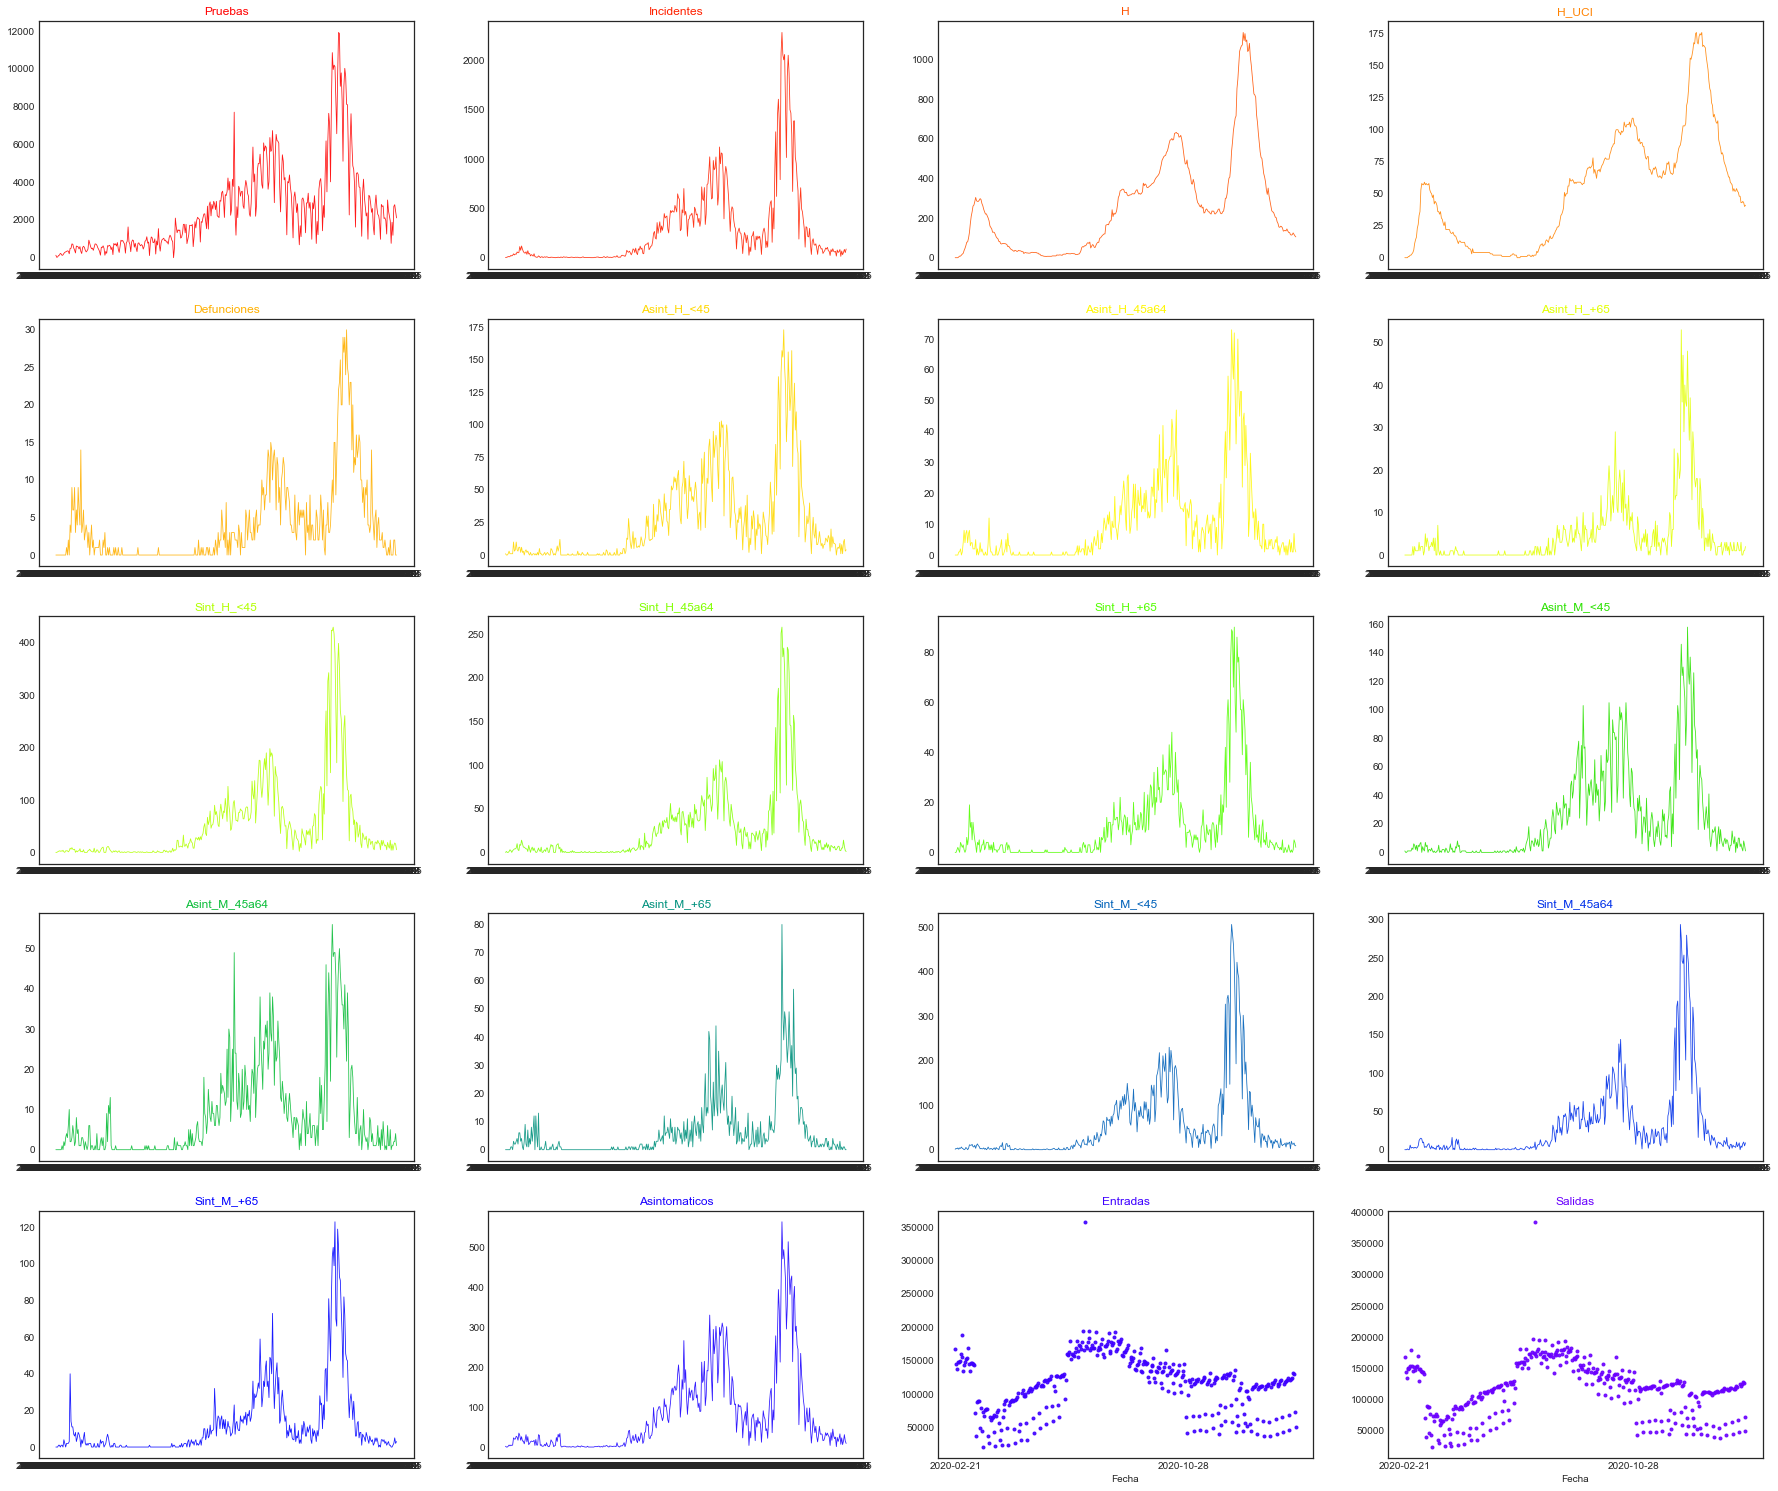

In [26]:
num = 0

# Initialize the figure style
plt.style.use('seaborn-white')
 
# create a color palette

palette = plt.get_cmap('prism')

for column in df_final_mitma:
    
    num = num + 1
 
    # Find the right spot on the plot
    plt.subplot(5,4, num)
 
    if "Salidas" in column or "Entradas" in column:
        serie = df_final_mitma[column]
        serie.plot(style = '.', color = palette(num), linewidth = 0.8, alpha = 0.9, label = column)
    else:
        # Plot the lineplot
        plt.plot(df_final_mitma[column], marker = '', color = palette(num), linewidth = 0.8, alpha = 0.9, label = column)

    # Add title
    plt.title(column, loc ='center', fontsize = 12, fontweight = 0, color = palette(num))

plt.subplots_adjust(left = 0.01, right = 4, top = 5, bottom = 0.01, hspace = 0.2, wspace = 0.2)


# Show the graph
plt.show()

## Predictor

In [ ]:
df_salud_murcia.isna().sum()

In [ ]:
df_final_mitma.head(5)

In [11]:
df_final_mitma['Sintomaticos'] = df_salud_murcia['Sint_H_<45'] + df_salud_murcia['Sint_H_45a64'] + df_salud_murcia['Sint_H_+65'] + df_salud_murcia['Sint_M_<45'] + df_salud_murcia['Sint_M_45a64'] + df_salud_murcia['Sint_M_+65']
df_final_mitma = df_final_mitma.drop(['Asint_H_<45', 'Asint_H_45a64', 'Asint_H_+65', 'Asint_M_<45', 'Asint_M_45a64', 'Asint_M_+65', 'Sint_H_<45', 'Sint_H_45a64', 'Sint_H_+65', 'Sint_M_<45', 'Sint_M_45a64', 'Sint_M_+65'], axis=1)
df_final_mitma.head(3)

NameError: name 'df_final_mitma' is not defined

In [ ]:
df_final_mitma.to_csv(path_or_buf = '../Datos_preprocesados/datos_mitma_final.csv')

In [ ]:
df_predictor = df_final_mitma.copy()
columnas = df_predictor.columns
#columnas = columnas.drop("Incidentes")
lista = []
# Añadimos lag a todas las series excepto a Incidentes, que es la que queremos predecir
for c in columnas:
    datos = pd.DataFrame(df_predictor[c].values, index = df_predictor.index)
    for i in [3,2,1]:
        df_predictor.insert(len(df_predictor.columns), c+' t-'+str(i),datos.shift(i))
        lista.append(df_predictor.columns)

columnas = columnas.drop("Incidentes")
df_predictor = df_predictor.drop(columnas, axis=1)

In [ ]:
df_predictor.head(4)

In [ ]:
df_predictor.shape

In [ ]:
df_predictor.isna().sum()

In [ ]:
df_predictor.dropna(axis = 0, inplace = True)
df_predictor.head(3)

In [ ]:
df_predictor.shape

In [ ]:
df_predictor.to_csv(path_or_buf = '../Datos_preprocesados/predictor.csv')

In [2]:
df_predictor = read_csv('../Datos_preprocesados/predictor.csv', encoding='latin-1', sep = ',', na_values = ['NaN', 'NaT'])
df_predictor = df_predictor.set_index('Fecha')
df_predictor.head(5)

,Incidentes,Pruebas t-3,Pruebas t-2,Pruebas t-1,Incidentes t-3,Incidentes t-2,Incidentes t-1,H t-3,H t-2,H t-1,...,Asintomaticos t-1,Entradas t-3,Entradas t-2,Entradas t-1,Salidas t-3,Salidas t-2,Salidas t-1,Sintomaticos t-3,Sintomaticos t-2,Sintomaticos t-1
Fecha,,,,,,,,,,,,,,,,,,,,,
2020-03-11,12.0,130.0,21.0,39.0,1.0,3.0,6.0,0.0,0.0,0.0,...,0.0,233114.055,312749.656,315375.300,226284.440,309733.557,315520.132,1.0,4.0,4.0
2020-03-12,9.0,21.0,39.0,116.0,3.0,6.0,12.0,0.0,0.0,0.0,...,2.0,312749.656,315375.300,317101.141,309733.557,315520.132,318225.510,4.0,4.0,10.0
2020-03-13,12.0,39.0,116.0,136.0,6.0,12.0,9.0,0.0,0.0,4.0,...,5.0,315375.300,317101.141,300505.264,315520.132,318225.510,306428.780,4.0,10.0,7.0
2020-03-14,23.0,116.0,136.0,228.0,12.0,9.0,12.0,0.0,4.0,8.0,...,3.0,317101.141,300505.264,269382.076,318225.510,306428.780,278294.481,10.0,7.0,9.0
2020-03-15,18.0,136.0,228.0,196.0,9.0,12.0,23.0,4.0,8.0,8.0,...,5.0,300505.264,269382.076,147957.126,306428.780,278294.481,151130.656,7.0,9.0,19.0


## Predictor sin movilidad

In [12]:
sin_mov = read_csv('../Datos_preprocesados/datos_murcia_mas_asintomaticos.csv', encoding='latin-1', sep = ',', na_values = ['NaN', 'NaT'])
sin_mov = sin_mov.set_index('Fecha')
sin_mov.head(3)

,Pruebas,Incidentes,H,H_UCI,Defunciones,Asint_H_<45,Asint_H_45a64,Asint_H_+65,Sint_H_<45,Sint_H_45a64,Sint_H_+65,Asint_M_<45,Asint_M_45a64,Asint_M_+65,Sint_M_<45,Sint_M_45a64,Sint_M_+65,Asintomaticos
Fecha,,,,,,,,,,,,,,,,,,
2020-03-08,130.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0
2020-03-09,21.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
2020-03-10,39.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [13]:
sin_mov['Sintomaticos'] = df_salud_murcia['Sint_H_<45'] + df_salud_murcia['Sint_H_45a64'] + df_salud_murcia['Sint_H_+65'] + df_salud_murcia['Sint_M_<45'] + df_salud_murcia['Sint_M_45a64'] + df_salud_murcia['Sint_M_+65']
sin_mov = sin_mov.drop(['Asint_H_<45', 'Asint_H_45a64', 'Asint_H_+65', 'Asint_M_<45', 'Asint_M_45a64', 'Asint_M_+65', 'Sint_H_<45', 'Sint_H_45a64', 'Sint_H_+65', 'Sint_M_<45', 'Sint_M_45a64', 'Sint_M_+65'], axis=1)
sin_mov.head(3)

,Pruebas,Incidentes,H,H_UCI,Defunciones,Asintomaticos,Sintomaticos
Fecha,,,,,,,
2020-03-08,130.0,1.0,0.0,0.0,0.0,2.0,1.0
2020-03-09,21.0,3.0,0.0,0.0,0.0,0.0,4.0
2020-03-10,39.0,6.0,0.0,0.0,0.0,0.0,4.0


In [14]:
pred_sin_mov = sin_mov.copy()
columnas = pred_sin_mov.columns
#columnas = columnas.drop("Incidentes")
lista = []
# Añadimos lag a todas las series excepto a Incidentes, que es la que queremos predecir
for c in columnas:
    datos = pd.DataFrame(pred_sin_mov[c].values, index = pred_sin_mov.index)
    for i in [3,2,1]:
        pred_sin_mov.insert(len(pred_sin_mov.columns), c+' t-'+str(i),datos.shift(i))
        lista.append(pred_sin_mov.columns)

columnas = columnas.drop("Incidentes")
pred_sin_mov = pred_sin_mov.drop(columnas, axis=1)

In [33]:
pred_sin_mov.dropna(axis = 0, inplace = True)
pred_sin_mov.head(3)

,Incidentes,Pruebas t-3,Pruebas t-2,Pruebas t-1,Incidentes t-3,Incidentes t-2,Incidentes t-1,H t-3,H t-2,H t-1,...,H_UCI t-1,Defunciones t-3,Defunciones t-2,Defunciones t-1,Asintomaticos t-3,Asintomaticos t-2,Asintomaticos t-1,Sintomaticos t-3,Sintomaticos t-2,Sintomaticos t-1
Fecha,,,,,,,,,,,,,,,,,,,,,
2020-03-11,12.0,130.0,21.0,39.0,1.0,3.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,4.0,4.0
2020-03-12,9.0,21.0,39.0,116.0,3.0,6.0,12.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,4.0,10.0
2020-03-13,12.0,39.0,116.0,136.0,6.0,12.0,9.0,0.0,0.0,4.0,...,1.0,0.0,0.0,0.0,0.0,2.0,5.0,4.0,10.0,7.0


In [34]:
pred_sin_mov.shape

(380, 22)

In [18]:
pred_sin_mov.to_csv(path_or_buf = '../Datos_preprocesados/predictor_sin_mov.csv')

In [81]:
pred_sin_mov = read_csv('../Datos_preprocesados/predictor_sin_mov.csv', encoding='latin-1', sep = ',', na_values = ['NaN', 'NaT'])
pred_sin_mov = pred_sin_mov.set_index('Fecha')
pred_sin_mov.head(5)

,Incidentes,Pruebas t-3,Pruebas t-2,Pruebas t-1,Incidentes t-3,Incidentes t-2,Incidentes t-1,H t-3,H t-2,H t-1,...,H_UCI t-1,Defunciones t-3,Defunciones t-2,Defunciones t-1,Asintomaticos t-3,Asintomaticos t-2,Asintomaticos t-1,Sintomaticos t-3,Sintomaticos t-2,Sintomaticos t-1
Fecha,,,,,,,,,,,,,,,,,,,,,
2020-03-11,12.0,130.0,21.0,39.0,1.0,3.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,4.0,4.0
2020-03-12,9.0,21.0,39.0,116.0,3.0,6.0,12.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,4.0,10.0
2020-03-13,12.0,39.0,116.0,136.0,6.0,12.0,9.0,0.0,0.0,4.0,...,1.0,0.0,0.0,0.0,0.0,2.0,5.0,4.0,10.0,7.0
2020-03-14,23.0,116.0,136.0,228.0,12.0,9.0,12.0,0.0,4.0,8.0,...,1.0,0.0,0.0,0.0,2.0,5.0,3.0,10.0,7.0,9.0
2020-03-15,18.0,136.0,228.0,196.0,9.0,12.0,23.0,4.0,8.0,8.0,...,2.0,0.0,0.0,0.0,5.0,3.0,5.0,7.0,9.0,19.0


# Random Forest

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics

En primer lugar seleccionamos el método que queremos utilizar, en nuestro caso es el regresor Random Forest

In [83]:
rf = RandomForestRegressor(random_state = 42)

Separamos nuestro conjunto de datos, 80% a train y 20% a test. En orden

In [84]:
X_train, X_test, y_train, y_test = train_test_split(pred_sin_mov.drop(['Incidentes'], axis=1),
                                        pred_sin_mov['Incidentes'], train_size = 0.8, test_size = 0.2, 
                                        random_state = 42, shuffle = False)

In [85]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((304, 21), (304,), (76, 21), (76,))

Lo siguiente que hacemos es hacer la búsqueda de hiperparámetros, para ello usaremos GridSearchCV, que prueba todas las 
posibles combinaciones de parámetros que se le pase usando crossvalidación. Veamos cuáles son los hiperparámetros de RF
y sus valores por defecto

In [86]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

- n_estimators: número de árboles 
- criterion: medida de calidad de cada división
- max_depth: la máxima profundidad del árbol
- min_samples_split: el mínimo número de muestras requeridas para dividir un nodo interno
- min_samples_lead: mínimo número de muestras requeridas para ser nodo hoja
- min_weight_fraction_lead: la fracción ponderada mínima de la suma total de pesos (de todas las muestras de entrada) necesaria para estar en un nodo hoja
- max_features: número de características miradas al buscar el mejor split ({auto, sqrt, log2})
- max_leaf_nodes: número máximo de nodos hoja
- n_jobs: número de trabajos a correr en paralelo
- max_samples: si hay bootstrapping es el número de muestras a extraer para estimar 
- ...

In [87]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Usamos el cross validator de time series
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits = 10)

grid = {
    'bootstrap': [True],
    'max_depth': [20, 50, 60, 70, 80],
    'max_features': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4, 5],
    'min_samples_split': [4, 8, 10, 14],
    'n_estimators': [100, 300, 500, 1000, 1500]
}

clf = GridSearchCV(estimator=RandomForestRegressor(), 
                    param_grid=grid,
                    cv=tscv,
                    refit=True,
                    error_score=0,
                    n_jobs=-1)

clf.fit(X_train, y_train)

# Random forest con los mejores hiperparámetros
optimised_random_forest = clf.best_estimator_
optimised_random_forest
clf.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'max_features': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 100}

Entrenamos ahora todo el conjunto de train con los mejores hiperparámetros obtenidos

In [88]:
optimised_random_forest.fit(X_train,y_train)

RandomForestRegressor(max_depth=20, max_features=5, min_samples_leaf=2,
                      min_samples_split=8)

Predecimos los datos de test

In [89]:
y_pred = optimised_random_forest.predict(X_test)

Finalmente calculamos el error cometido (uso MAE)

In [90]:
import sklearn.metrics as sm
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 2)) 

Mean absolute error = 233.08


In [94]:
import sklearn.metrics as sm
import math
print("RMSE =", round(math.sqrt(sm.mean_squared_error(y_test, y_pred)), 2))

RMSE = 409.11


Intentamos mostrar las predicciones y los valores reales en una gráfica. Aprovechando que tenemos la serie de valores
reales a predecir, añadimos en un dataframe los valores predecidos y mostramos ambos según las fechas

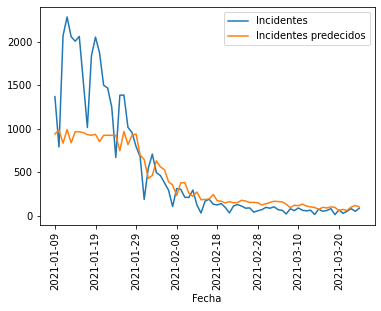

In [92]:
from matplotlib import pyplot
df_y = pd.DataFrame(y_test)
df_y['Incidentes predecidos'] = y_pred
df_y.plot()
pyplot.xticks(rotation=90)
pyplot.show()

In [93]:
np.corrcoef(y_test, y_pred)

array([[1.        , 0.89067186],
       [0.89067186, 1.        ]])

## Normalización de datos

En este apartado realizamos una normalización de los atributos de nuestros datos. Para ello usamos el normalizador que 
ofrece Python llamado Max-Min Scaler

Nos quedamos con el índice del dataframe para luego poder añadirselo al nuevo dataframe escalado

In [59]:
index = pred_sin_mov.index

Normalización con max-min scaler

In [66]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
escalado = scaler.fit_transform(pred_sin_mov)
df_escalado = pd.DataFrame(escalado, columns = pred_sin_mov.columns).set_index(index)
df_escalado.head(3)

,Incidentes,Pruebas t-3,Pruebas t-2,Pruebas t-1,Incidentes t-3,Incidentes t-2,Incidentes t-1,H t-3,H t-2,H t-1,...,H_UCI t-1,Defunciones t-3,Defunciones t-2,Defunciones t-1,Asintomaticos t-3,Asintomaticos t-2,Asintomaticos t-1,Sintomaticos t-3,Sintomaticos t-2,Sintomaticos t-1
Fecha,,,,,,,,,,,,,,,,,,,,,
2020-03-11,0.005256,0.010901,0.001761,0.003270,0.000438,0.001314,0.002628,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.00354,0.00000,0.00000,0.000604,0.002415,0.002415
2020-03-12,0.003942,0.001761,0.003270,0.009727,0.001314,0.002628,0.005256,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.00000,0.00000,0.00354,0.002415,0.002415,0.006039
2020-03-13,0.005256,0.003270,0.009727,0.011404,0.002628,0.005256,0.003942,0.0,0.0,0.003521,...,0.005682,0.0,0.0,0.0,0.00000,0.00354,0.00885,0.002415,0.006039,0.004227


In [69]:
rf = RandomForestRegressor(random_state = 42)

X_train, X_test, y_train, y_test = train_test_split(df_escalado.drop(['Incidentes'], axis=1),
                                        df_escalado['Incidentes'], train_size = 0.8, test_size = 0.2, 
                                        random_state = 42, shuffle = False)

In [70]:
X_train.shape

(304, 21)

In [71]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Usamos el cross validator de time series
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits = 10)

grid = {
    'bootstrap': [True],
    'max_depth': [20, 50, 60, 70, 80],
    'max_features': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4, 5],
    'min_samples_split': [4, 8, 10, 14],
    'n_estimators': [100, 300, 500, 1000, 1500]
}

clf = GridSearchCV(estimator=RandomForestRegressor(), 
                    param_grid=grid,
                    cv=tscv,
                    refit=True,
                    error_score=0,
                    n_jobs=-1)

clf.fit(X_train, y_train)

# Random forest con los mejores hiperparámetros
optimised_random_forest = clf.best_estimator_
optimised_random_forest

RandomForestRegressor(max_depth=70, max_features=5, min_samples_leaf=4,
                      min_samples_split=10)

In [72]:
optimised_random_forest.fit(X_train,y_train)

RandomForestRegressor(max_depth=70, max_features=5, min_samples_leaf=4,
                      min_samples_split=10)

In [73]:
y_pred = optimised_random_forest.predict(X_test)

In [74]:
import sklearn.metrics as sm
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 2)) 

Mean absolute error = 0.11


In [75]:
import sklearn.metrics as sm
import math
print("RMSE =", round(math.sqrt(sm.mean_squared_error(y_test, y_pred)), 2))

RMSE = 0.19


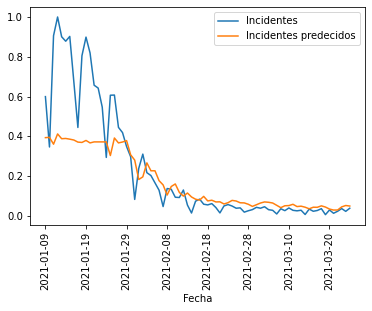

In [76]:
from matplotlib import pyplot
df_y = pd.DataFrame(y_test)
df_y['Incidentes predecidos'] = y_pred
df_y.plot()
pyplot.xticks(rotation=90)
pyplot.show()

# Regresión lineal

## Con movilidad

In [3]:
df_predictor = read_csv('../Datos_preprocesados/predictor.csv', encoding='latin-1', sep = ',', na_values = ['NaN', 'NaT'])
df_predictor = df_predictor.set_index('Fecha')
df_predictor.head(3)

,Incidentes,Pruebas t-3,Pruebas t-2,Pruebas t-1,Incidentes t-3,Incidentes t-2,Incidentes t-1,H t-3,H t-2,H t-1,...,Asintomaticos t-1,Entradas t-3,Entradas t-2,Entradas t-1,Salidas t-3,Salidas t-2,Salidas t-1,Sintomaticos t-3,Sintomaticos t-2,Sintomaticos t-1
Fecha,,,,,,,,,,,,,,,,,,,,,
2020-03-11,12.0,130.0,21.0,39.0,1.0,3.0,6.0,0.0,0.0,0.0,...,0.0,233114.055,312749.656,315375.300,226284.440,309733.557,315520.132,1.0,4.0,4.0
2020-03-12,9.0,21.0,39.0,116.0,3.0,6.0,12.0,0.0,0.0,0.0,...,2.0,312749.656,315375.300,317101.141,309733.557,315520.132,318225.510,4.0,4.0,10.0
2020-03-13,12.0,39.0,116.0,136.0,6.0,12.0,9.0,0.0,0.0,4.0,...,5.0,315375.300,317101.141,300505.264,315520.132,318225.510,306428.780,4.0,10.0,7.0


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_predictor.drop(['Incidentes'], axis=1),
                                        df_predictor['Incidentes'], train_size = 0.8, test_size = 0.2, 
                                        random_state = 42, shuffle = False)

In [9]:
from sklearn.linear_model import LinearRegression 

In [10]:
regresion_lineal = LinearRegression()

In [11]:
regresion_lineal.fit(X_train, y_train) 

LinearRegression()

In [12]:
y_pred = regresion_lineal.predict(X_test)

In [15]:
import sklearn.metrics as sm
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 2))

Mean absolute error = 195.53


In [13]:
import sklearn.metrics as sm
import math
print("RMSE =", round(math.sqrt(sm.mean_squared_error(y_test, y_pred)), 2))

RMSE = 292.89


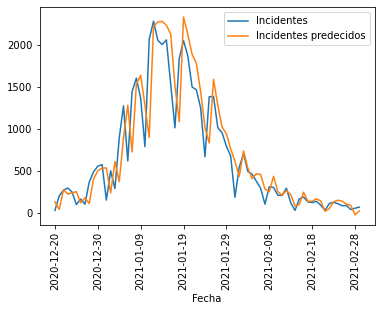

In [14]:
from matplotlib import pyplot
df_y = pd.DataFrame(y_test)
df_y['Incidentes predecidos'] = y_pred
df_y.plot()
pyplot.xticks(rotation=90)
pyplot.show()